# Import библиотек

In [15]:
from zipfile import ZipFile
import os
from PIL import Image
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
from scipy.spatial.distance import cosine

# Набор данных

## Загрузка данных

In [3]:
zip_file_path = '/content/drive/MyDrive/ML-projects/women-fashion.zip'
extraction_directory = '/content/women_fashion/'

if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

extracted_files = os.listdir(extraction_directory)
print(extracted_files[:10])

['__MACOSX', 'women fashion']


## Просмотр набора данных

Посмотрим на наши файлы

In [4]:
extraction_directory_updated = os.path.join(extraction_directory, 'women fashion')
extracted_files_updated = os.listdir(extraction_directory_updated)
extracted_files_updated[:10], len(extracted_files_updated)

(['fluffy, possibly faux fur or eyelash knit sweater with a cropped cut top.jpg',
  'strapless red midi dress with a mermaid silhouette.jpg',
  'red dress adorned with an intricate white pattern.jpg',
  'anarkali suit with lavender in color with intricate white patterns throughout the fabric.jpg',
  'short, white, sleeveless dress with thin straps.jpg',
  'long, elegant, teal dress with a high slit on one side.jpg',
  'fitted black dress that reaches down to mid-calf.jpg',
  'Sleeveless-Ruched-Tight-Fashion-Sexy-Bodycon-Party-Women-Club-Dresses.webp',
  'light green, short dress with lace detailing around the waist and the edges of the sleeves and hem.jpg',
  'white dress adorned with colorful floral patterns.jpg'],
 97)

Посмотрим на содержимое в виде картинки

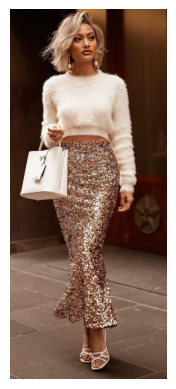

In [6]:
def display_image(file_path):
    image = Image.open(file_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

first_image_path = os.path.join(extraction_directory_updated, extracted_files_updated[0])
display_image(first_image_path)

# Создание рекомендательной системы

## Подготовка данных

In [9]:
image_directory = '/content/women_fashion/women fashion'

image_paths_list = [file for file in glob.glob(os.path.join(image_directory, '*.*')) if file.endswith(('.jpg', '.png', '.jpeg', 'webp'))]

print(image_paths_list)

['/content/women_fashion/women fashion/fluffy, possibly faux fur or eyelash knit sweater with a cropped cut top.jpg', '/content/women_fashion/women fashion/strapless red midi dress with a mermaid silhouette.jpg', '/content/women_fashion/women fashion/red dress adorned with an intricate white pattern.jpg', '/content/women_fashion/women fashion/anarkali suit with lavender in color with intricate white patterns throughout the fabric.jpg', '/content/women_fashion/women fashion/short, white, sleeveless dress with thin straps.jpg', '/content/women_fashion/women fashion/long, elegant, teal dress with a high slit on one side.jpg', '/content/women_fashion/women fashion/fitted black dress that reaches down to mid-calf.jpg', '/content/women_fashion/women fashion/Sleeveless-Ruched-Tight-Fashion-Sexy-Bodycon-Party-Women-Club-Dresses.webp', '/content/women_fashion/women fashion/light green, short dress with lace detailing around the waist and the edges of the sleeves and hem.jpg', '/content/women_fa

## Модель

In [11]:
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

58889256/58889256 [==============================] - 2s 0us/step


## Вспомогательные функции

In [12]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

def extract_features(model, preprocessed_img):
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / np.linalg.norm(flattened_features)
    return normalized_features

## Извлечение признаков

In [13]:
all_features = []
all_image_names = []

for img_path in image_paths_list:
    preprocessed_img = preprocess_image(img_path)
    features = extract_features(model, preprocessed_img)
    all_features.append(features)
    all_image_names.append(os.path.basename(img_path))

1/1 [==============================] - 1s 950ms/step


## Создание функции для системы

In [18]:
def recommend_fashion_items_cnn(input_image_path, all_features, all_image_names, model, top_n=5):
    preprocessed_img = preprocess_image(input_image_path)
    input_features = extract_features(model, preprocessed_img)

    similarities = [1 - cosine(input_features, other_feature) for other_feature in all_features]
    similar_indices = np.argsort(similarities)[-top_n:]

    similar_indices = [idx for idx in similar_indices if idx != all_image_names.index(input_image_path)]

    plt.figure(figsize=(15, 10))
    plt.subplot(1, top_n + 1, 1)
    plt.imshow(Image.open(input_image_path))
    plt.title("Исходное изображение")
    plt.axis('off')

    for i, idx in enumerate(similar_indices[:top_n], start=1):
        image_path = os.path.join('/content/women_fashion/women fashion', all_image_names[idx])
        plt.subplot(1, top_n + 1, i + 1)
        plt.imshow(Image.open(image_path))
        plt.title(f"Рекомендованный образ {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Пример реализации рекомендательной системы

1/1 [==============================] - 1s 538ms/step


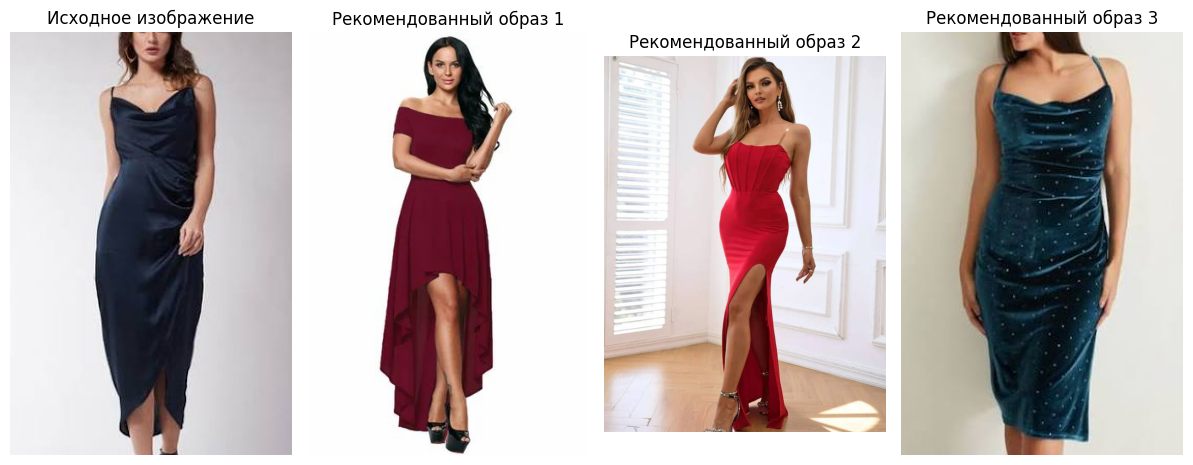

In [19]:
input_image_path = '/content/women_fashion/women fashion/dark, elegant, sleeveless dress that reaches down to about mid-calf.jpg'
recommend_fashion_items_cnn(input_image_path, all_features, image_paths_list, model, top_n=4)

1/1 [==============================] - 1s 549ms/step


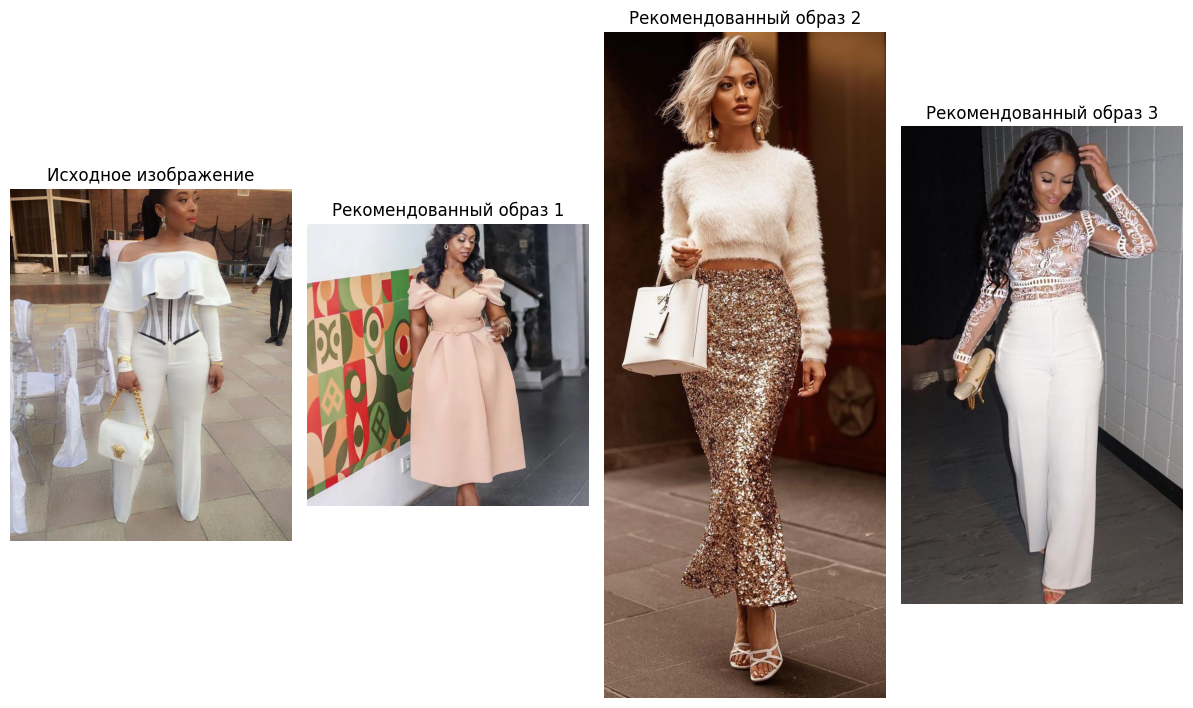

In [22]:
input_image_path = '/content/women_fashion/women fashion/high-waisted white trousers paired with a structured, corset-style bodice featuring mesh.jpg'
recommend_fashion_items_cnn(input_image_path, all_features, image_paths_list, model, top_n=4)

Как видно образы подбирает примерно похожие в одном фасоне